In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housing/target.csv
/kaggle/input/housing/train.csv
/kaggle/input/housing/test.csv
/kaggle/input/housing/AmesHousing.csv


In [90]:
#Import Libraries
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
import plotly.express as px
import matplotlib.pyplot as plt

In [91]:
#Load data using the warngle function
df = wrangle("/kaggle/input/housing/AmesHousing.csv")
print("df shape:", df.shape)
df.head()


df shape: (127, 73)


,Lot Frontage,Lot Area,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
51,100.0,18494,Corner,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,199500
60,60.0,17433,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,355000
64,58.0,16770,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,7,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,221000
128,120.0,17360,Corner,Gtl,NAmes,Artery,Norm,1Fam,1.5Fin,6,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,172500
157,78.0,17503,Inside,Gtl,NAmes,Artery,Norm,1Fam,1.5Fin,6,...,0,NaN,NaN,NaN,0,1,2010,WD,Abnorml,97500


In [92]:
df["TotRms AbvGrd"].unique()

array([ 6,  7,  8, 11,  9, 10,  5, 12,  4, 15])

In [93]:
#using the wrangle function to create a subset with: houses with Paved streets,lot area >15000, SalePrice < 600_000
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
        # Subset data: Houses with paved streets", lot area more than 15 000, Sale Price < 600 00
    mask_st = df["Street"] == "Pave"
    mask_price = df["SalePrice"] < 600_000
    mask_la = df["Lot Area"] > 15_000
    
    df = df[mask_st & mask_price & mask_la]
    
    # Subset data: Remove outliers for "Lot Frontage"
    low, high = df["Lot Frontage"].quantile([0.1, 0.9])
    mask_area = df["Lot Frontage"].between(low, high)
    df = df[mask_area]
    
    #drop columns we do not need
    df.drop(columns="Alley", inplace=True)
    
    #Drop low and high cardinality categorical variables
    df.drop(columns=[
        "Order",
        "PID",
        "MS SubClass",
        "MS Zoning",
        "Street",
        "Lot Shape",
        "Land Contour",
        "Utilities",
        
    ], 
            inplace=True)



    return df

In [94]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 51 to 2923
Data columns (total 73 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Lot Frontage     127 non-null    float64
 1   Lot Area         127 non-null    int64  
 2   Lot Config       127 non-null    object 
 3   Land Slope       127 non-null    object 
 4   Neighborhood     127 non-null    object 
 5   Condition 1      127 non-null    object 
 6   Condition 2      127 non-null    object 
 7   Bldg Type        127 non-null    object 
 8   House Style      127 non-null    object 
 9   Overall Qual     127 non-null    int64  
 10  Overall Cond     127 non-null    int64  
 11  Year Built       127 non-null    int64  
 12  Year Remod/Add   127 non-null    int64  
 13  Roof Style       127 non-null    object 
 14  Roof Matl        127 non-null    object 
 15  Exterior 1st     127 non-null    object 
 16  Exterior 2nd     127 non-null    object 
 17  Mas Vnr Type  

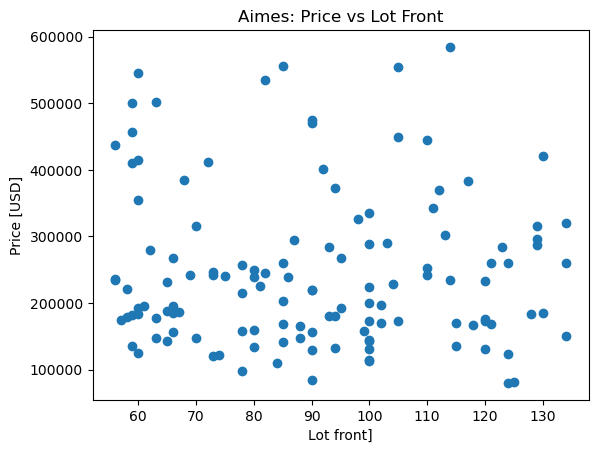

In [95]:
#Lets explore the relationship between Lot Frontage and SalePrice
#we see that there are some outliers, its best to remove them
df["Lot Frontage"].mean()
plt.scatter(x=df["Lot Frontage"], y=df["SalePrice"])
plt.xlabel("Lot front]")
plt.ylabel("Price [USD]")
plt.title("Aimes: Price vs Lot Front");


In [96]:
#we need to keep an eye out for is multicollinearity,
#that is, features in our feature matrix that are highly correlated with each other. 
#A good way to detect this is to use a correlation matrix. Let's make one!

corr = df.select_dtypes("number").drop(columns="SalePrice").corr()
corr



,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold
Lot Frontage,1.000000,-0.012092,0.024662,-0.121470,-0.021498,-0.005136,0.160368,0.048076,0.094716,0.087123,...,0.171504,-0.099701,0.309338,0.074726,0.171361,-0.029903,-0.021278,0.142082,0.036938,0.041851
Lot Area,-0.012092,1.000000,-0.065908,0.061161,-0.123134,-0.065160,-0.048766,0.138924,-0.015764,-0.058835,...,0.079643,0.260226,0.177237,0.035403,-0.008621,-0.062992,-0.009398,0.204593,0.245505,-0.152903
Overall Qual,0.024662,-0.065908,1.000000,0.065495,0.513758,0.559187,0.557343,0.425747,0.043127,0.240773,...,0.586202,0.295044,0.229152,-0.152064,0.018970,0.074955,0.016112,0.161639,0.032264,-0.109002
Overall Cond,-0.121470,0.061161,0.065495,1.000000,-0.452908,0.103451,-0.185841,-0.056336,-0.004019,0.001864,...,-0.121786,0.023389,-0.038279,-0.072518,-0.030579,0.195430,-0.050931,-0.040899,-0.045498,0.171108
Year Built,-0.021498,-0.123134,0.513758,-0.452908,1.000000,0.520041,0.420209,0.347112,-0.017733,0.103727,...,0.227571,0.150443,0.076701,-0.135493,0.092805,-0.176121,0.048734,0.091554,-0.107854,-0.100896
Year Remod/Add,-0.005136,-0.065160,0.559187,0.103451,0.520041,1.000000,0.326241,0.240303,-0.016094,0.075839,...,0.288547,0.228337,0.225735,-0.193231,0.085125,-0.100097,-0.032191,0.089796,-0.061107,0.083850
Mas Vnr Area,0.160368,-0.048766,0.557343,-0.185841,0.420209,0.326241,1.000000,0.519899,0.045837,0.038323,...,0.501897,0.193233,0.232579,-0.128524,0.106481,-0.046618,-0.040558,0.369727,-0.065418,-0.083121
BsmtFin SF 1,0.048076,0.138924,0.425747,-0.056336,0.347112,0.240303,0.519899,1.000000,0.002502,-0.323574,...,0.365746,0.282235,0.233898,-0.152489,-0.073439,-0.068662,-0.057086,0.455769,0.049929,0.013437
BsmtFin SF 2,0.094716,-0.015764,0.043127,-0.004019,-0.017733,-0.016094,0.045837,0.002502,1.000000,-0.262405,...,0.049805,0.098329,0.090673,-0.019452,-0.028637,0.316185,0.079933,-0.002851,-0.050529,0.031419
Bsmt Unf SF,0.087123,-0.058835,0.240773,0.001864,0.103727,0.075839,0.038323,-0.323574,-0.262405,1.000000,...,0.174766,0.012540,0.094478,0.062866,0.128625,0.017654,-0.033514,0.059311,0.046538,-0.131870


In [74]:
#We can see from the correlation matrix above that most features(columns) are not linearly correlated

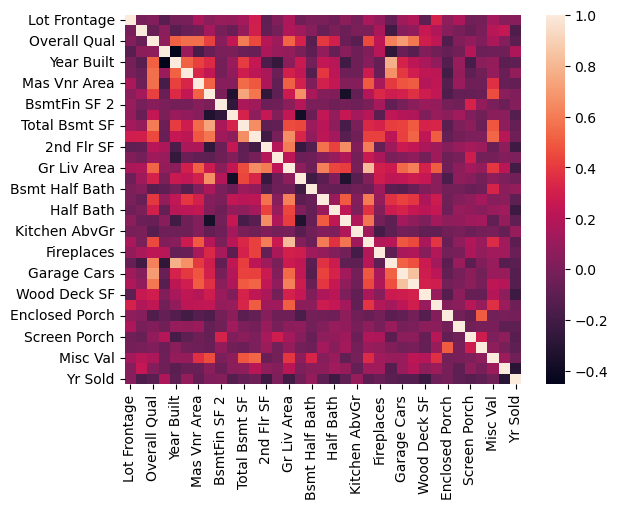

In [98]:
#Another way to check for multicollinearity is through a heatmap!
corr = df.select_dtypes("number").drop(columns="SalePrice").corr()
sns.heatmap(corr);


In [99]:
#Since there are still a lot of features(73) and we only want to keep 4 features, instead of dropping columns, which will be cumbersome, we will create a new DataFrame and keep columns

df1 = df[["Lot Frontage", "Lot Area", "TotRms AbvGrd", "Sale Condition"]]
df1.head()

,Lot Frontage,Lot Area,TotRms AbvGrd,Sale Condition
51,100.0,18494,6,Normal
60,60.0,17433,7,Normal
64,58.0,16770,7,Normal
128,120.0,17360,6,Normal
157,78.0,17503,6,Abnorml


In [100]:
#Lets split the data
target = "SalePrice"
features = ["Lot Frontage", "Lot Area", "TotRms AbvGrd", "Sale Condition"]
y_train = df[target]
X_train = df[features]


In [101]:
X_train.head()

,Lot Frontage,Lot Area,TotRms AbvGrd,Sale Condition
51,100.0,18494,6,Normal
60,60.0,17433,7,Normal
64,58.0,16770,7,Normal
128,120.0,17360,6,Normal
157,78.0,17503,6,Abnorml


In [102]:
#Building the Model
# Lets start by calculating the baseline mean absolute error for our model.
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean house price:", round(y_mean, 2))

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))


Mean house price: 246565.64
Baseline MAE: 90447.13993427984


In [103]:
# Now lets Iterate
# Lets create a pipeline named model that contains a OneHotEncoder, SimpleImputer, and Ridge predictor.

model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train, y_train)



Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Sale Condition'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [104]:
#Evaluate
# Lets calculate the training mean absolute error for our predictions as compared to the true targets in y_train.
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))



Training MAE: 73736.00190653153


In [82]:
# Hooray we have beat our baseline so our model is doing good.

In [105]:
# import the test data into a DataFrame and generate a list of predictions using the model. 
df2 = pd.read_csv("/kaggle/input/housing/test.csv")
ft = [["Lot Frontage", "Lot Area", "TotRms AbvGrd", "Sale Condition"]]
X_test = df2[["Lot Frontage", "Lot Area", "TotRms AbvGrd", "Sale Condition"]]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()


0    209842.254108
1    263621.160816
2    303689.493311
3    302067.243130
4    250470.845473
dtype: float64

# Communicate Results

In [84]:
# Communicate Results
#let's look at two ways we might deploy this model
#One way is to wrap the model in a function so that a programmer can provide inputs and then receive a prediction as output.
#Create a function make_prediction that takes four arguments (area, lat, lon, and neighborhood) and returns your model's prediction for an apartment price.


In [106]:

def make_prediction(Lot, area, Rooms, Condition):
    data = {
        "Lot Frontage":Lot,
        "Lot Area": area,
        "TotRms AbvGrd": Rooms,
        "Sale Condition": Condition
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

#Let's see if our function works. Run the cell below to find out!

make_prediction(95, 18_000, 6, "Family")


'Predicted apartment price: $254702.16'

Viola !! Our function is working perfectly

Here is another way to deploy our function:
We add our make_prediction to the interact widget below, run the cell, and then adjust the widget to see how predicted apartment price changes.



In [108]:
#Create an interact function in Jupyter Widgets.
interact(
    make_prediction,
    Lot=FloatSlider(
        min=X_train["Lot Frontage"].min(),
        max=X_train["Lot Frontage"].max(),
        step=0.01,
        value=X_train["Lot Frontage"].mean(),
    ),
    area=FloatSlider(
        min=X_train["Lot Area"].min(),
        max=X_train["Lot Area"].max(),
        step=0.01,
        value=X_train["Lot Area"].mean(),
    ),
    Rooms=IntSlider(
        min=X_train["TotRms AbvGrd"].min(),
        max=X_train["TotRms AbvGrd"].max(),
        value=X_train["TotRms AbvGrd"].mean(),
    ),
    Condition=Dropdown(options=sorted(X_train["Sale Condition"].unique())),
);


'Predicted apartment price: $155197.23'